# Pair Trading Strategies:
## z-score model and finding a better performing model
### Submitted by: Abhisek Kumar Gupta
### MS-QMS 2023-2025, ISI Bangalore

**Step 1: Preparing the data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_parquet(r"D:\PairTrading\data.parquet")

# Reset index and add index column
df.reset_index(inplace=True)

# Output the DataFrame with the index column
df

,time,banknifty,nifty,tte
0,2021-01-01 09:15:00,0.286058,0.199729,27
1,2021-01-01 09:16:00,0.285381,0.200433,27
2,2021-01-01 09:17:00,0.284233,0.200004,27
3,2021-01-01 09:18:00,0.286104,0.199860,27
4,2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28
690508,2022-06-30 15:27:00,0.240875,0.216558,28
690509,2022-06-30 15:28:00,0.242115,0.216794,28
690510,2022-06-30 15:29:00,0.243426,0.216455,28


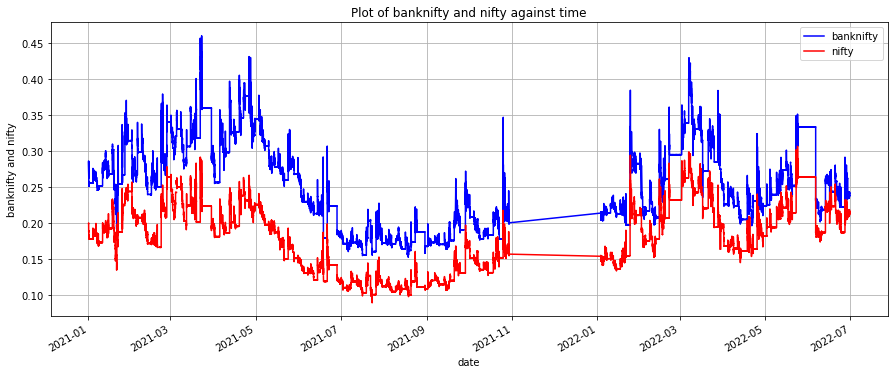

In [2]:
df.plot(x='time', y=['banknifty', 'nifty'], figsize=(15, 6), color=['blue', 'red'], grid=True)
plt.xlabel('date')
plt.ylabel('banknifty and nifty')
plt.title('Plot of banknifty and nifty against time')
plt.legend()
plt.show()

**This dataset has repeated values at the time of market closer for bussiness hours timing and holidays. So, those rows should be removed.**

In [3]:
# Filter data for Monday to Friday
df = df[df['time'].dt.dayofweek <= 4]  # Monday is 0, Friday is 4

# Filter data between 9:15 am and 3:30 pm
df = df[(df['time'].dt.hour > 9) | ((df['time'].dt.hour == 9) & (df['time'].dt.minute >= 15))]  # After 9:15 am
df = df[(df['time'].dt.hour < 15) | ((df['time'].dt.hour == 15) & (df['time'].dt.minute <= 30))]  # Before 3:30 pm

df

,time,banknifty,nifty,tte
0,2021-01-01 09:15:00,0.286058,0.199729,27
1,2021-01-01 09:16:00,0.285381,0.200433,27
2,2021-01-01 09:17:00,0.284233,0.200004,27
3,2021-01-01 09:18:00,0.286104,0.199860,27
4,2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28
690508,2022-06-30 15:27:00,0.240875,0.216558,28
690509,2022-06-30 15:28:00,0.242115,0.216794,28
690510,2022-06-30 15:29:00,0.243426,0.216455,28


In [4]:
df['Date'] = df['time'].dt.date
df['Time'] = df['time'].dt.time

# Drop the original 'datetime_column' if needed
# df.drop(columns=['datetime_column'], inplace=True)

df

,time,banknifty,nifty,tte,Date,Time
0,2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01,09:15:00
1,2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01,09:16:00
2,2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01,09:17:00
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,09:18:00
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,09:19:00
...,...,...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,15:26:00
690508,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,15:27:00
690509,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,15:28:00
690510,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,15:29:00


In [5]:
# Create a new column with day names
df['day_names'] = df['time'].dt.day_name()

df

,time,banknifty,nifty,tte,Date,Time,day_names
0,2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01,09:15:00,Friday
1,2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01,09:16:00,Friday
2,2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01,09:17:00,Friday
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,09:18:00,Friday
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,09:19:00,Friday
...,...,...,...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,15:26:00,Thursday
690508,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,15:27:00,Thursday
690509,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,15:28:00,Thursday
690510,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,15:29:00,Thursday


**The lists of market holidays are taken from:**
**https://www.5paisa.com/stock-market-holidays-2021**
**https://www.5paisa.com/stock-market-holidays-2022**

In [6]:
# Read the Holiday Excel sheet into a DataFrame
excel_df = pd.read_excel(r"D:\PairTrading\NSE_Holidays2021_2022.xlsx")

# Extract the dates from the column
excel_dates = excel_df['Holidays'].dt.date

# Remove rows where date from the 'Date' column of the dataframe matches any date from the Holidays Excel sheet column
df = df[~(df['Date'].isin(excel_dates))]

df

,time,banknifty,nifty,tte,Date,Time,day_names
0,2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01,09:15:00,Friday
1,2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01,09:16:00,Friday
2,2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01,09:17:00,Friday
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,09:18:00,Friday
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,09:19:00,Friday
...,...,...,...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,15:26:00,Thursday
690508,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,15:27:00,Thursday
690509,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,15:28:00,Thursday
690510,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,15:29:00,Thursday


**Let's check for missing values and replace them with the average of 5 previous values and 5 next values.**

In [7]:
missing_values = df.isnull().sum()

# Print the number of missing values along with column names
for column_name, missing_count in missing_values.items():
    print(f"Column '{column_name}' has {missing_count} missing values.")

Column 'time' has 0 missing values.
Column 'banknifty' has 253 missing values.
Column 'nifty' has 336 missing values.
Column 'tte' has 0 missing values.
Column 'Date' has 0 missing values.
Column 'Time' has 0 missing values.
Column 'day_names' has 0 missing values.


In [8]:
# Define a rolling window of size 11 (5 previous + 5 next + current value)
rolling_window1 = df['banknifty'].rolling(window=11, min_periods=1, center=True)
rolling_window2 = df['nifty'].rolling(window=11, min_periods=1, center=True)

# Calculate the mean of the rolling window
mean_values1 = rolling_window1.mean()
mean_values2 = rolling_window2.mean()

# Fill blank cells with the calculated mean values
df['banknifty'] = df['banknifty'].fillna(mean_values1)
df['nifty'] = df['nifty'].fillna(mean_values2)

df

,time,banknifty,nifty,tte,Date,Time,day_names
0,2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01,09:15:00,Friday
1,2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01,09:16:00,Friday
2,2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01,09:17:00,Friday
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,09:18:00,Friday
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,09:19:00,Friday
...,...,...,...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,15:26:00,Thursday
690508,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,15:27:00,Thursday
690509,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,15:28:00,Thursday
690510,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,15:29:00,Thursday


In [9]:
missing_values1 = df.isnull().sum()

# Print the number of missing values along with column names
for column_name, missing_count in missing_values1.items():
    print(f"Column '{column_name}' has {missing_count} missing values.")

Column 'time' has 0 missing values.
Column 'banknifty' has 0 missing values.
Column 'nifty' has 0 missing values.
Column 'tte' has 0 missing values.
Column 'Date' has 0 missing values.
Column 'Time' has 0 missing values.
Column 'day_names' has 0 missing values.


**Now, there is no missing values and market closer time data are removed**

**Let us check for stationarity**

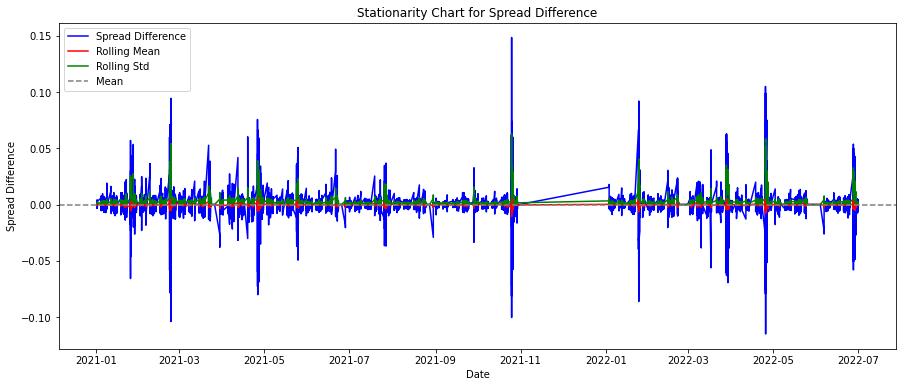

In [10]:
# Plot the time series data

df['spread'] = df['banknifty'] - df['nifty']

df['spread_diff3']=df['spread'].diff(3)

plt.figure(figsize=(15, 6))
plt.plot(df['time'], df['spread_diff3'], color='blue', label='Spread Difference')

# Add rolling statistics
rolling_mean = df['spread_diff3'].rolling(window=30).mean()
rolling_std = df['spread_diff3'].rolling(window=30).std()
plt.plot(df['time'], rolling_mean, color='red', label='Rolling Mean')
plt.plot(df['time'], rolling_std, color='green', label='Rolling Std')

# Add horizontal line for mean
plt.axhline(df['spread_diff3'].mean(), color='gray', linestyle='--', label='Mean')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Spread Difference')
plt.title('Stationarity Chart for Spread Difference')
plt.legend()

# Show plot
plt.show()

<Figure size 720x432 with 0 Axes>

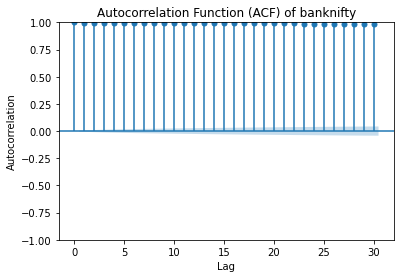

<Figure size 720x432 with 0 Axes>

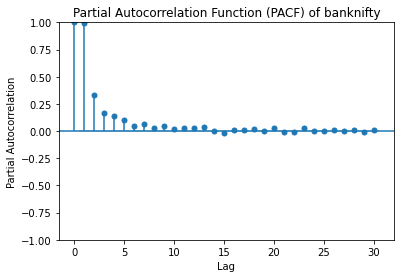

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF for banknifty
plt.figure(figsize=(10, 6))
plot_acf(df['banknifty'], lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of banknifty')
plt.show()

# Plot PACF for banknifty
plt.figure(figsize=(10, 6))
plot_pacf(df['banknifty'], lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) of banknifty')
plt.show()

<Figure size 720x432 with 0 Axes>

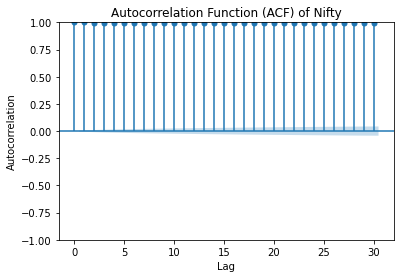

<Figure size 720x432 with 0 Axes>

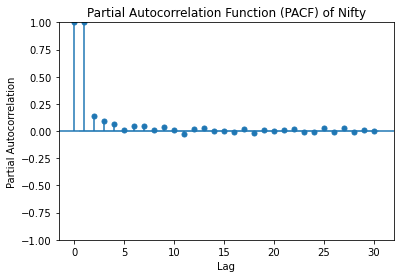

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF for nifty
plt.figure(figsize=(10, 6))
plot_acf(df['nifty'], lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Nifty')
plt.show()

# Plot PACF for nifty
plt.figure(figsize=(10, 6))
plot_pacf(df['nifty'], lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) of Nifty')
plt.show()

<Figure size 720x432 with 0 Axes>

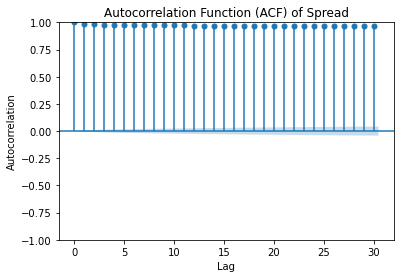

<Figure size 720x432 with 0 Axes>

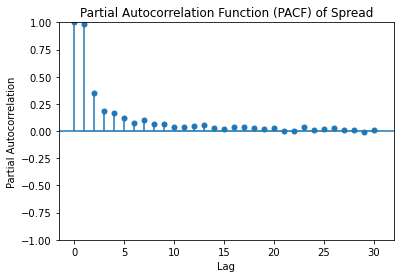

In [13]:
# Plot ACF for spread
plt.figure(figsize=(10, 6))
plot_acf(df['spread'], lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Spread')
plt.show()

# Plot PACF for spread
plt.figure(figsize=(10, 6))
plot_pacf(df['spread'], lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) of Spread')
plt.show()

**The data is suitable for time series modeling.**
**Now, we can apply our models.**

**Step 2: Base Model: Z-Score Trading System**

In [14]:
# Simulate trading based on z-score signals
import numpy as np
from scipy.stats import zscore

data = df.copy()

data['spread_zscore'] = zscore(data['spread'])

# Trading logic based on z-score
# When z-score > 1, short Bank Nifty and long Nifty (negative position)
# When z-score < -1, long Bank Nifty and short Nifty (positive position)
# Otherwise, no position (neutral)
data['position_zscore'] = np.where(data['spread_zscore'] > 1, -1, 
                                   np.where(data['spread_zscore'] < -1, 1, 0))

# Print out the description of position_zscore values
print("Position Description:")
print("-1: Short Bank Nifty, Long Nifty")
print(" 0: Neutral Position")
print(" 1: Long Bank Nifty, Short Nifty")

# Calculate P/L using the provided formula
data['P/L_base'] = data['spread'] * (data['tte'] ** 0.7)
data

Position Description:
-1: Short Bank Nifty, Long Nifty
 0: Neutral Position
 1: Long Bank Nifty, Short Nifty


,time,banknifty,nifty,tte,Date,Time,day_names,spread,spread_diff3,spread_zscore,position_zscore,P/L_base
0,2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01,09:15:00,Friday,0.086329,NaN,0.516009,0,0.867184
1,2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01,09:16:00,Friday,0.084948,NaN,0.463850,0,0.853317
2,2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01,09:17:00,Friday,0.084229,NaN,0.436666,0,0.846089
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,09:18:00,Friday,0.086244,-0.000085,0.512778,0,0.866325
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,09:19:00,Friday,0.086588,0.001640,0.525794,0,0.869786
...,...,...,...,...,...,...,...,...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,15:26:00,Thursday,0.025943,0.000302,-1.765519,1,0.267320
690508,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,15:27:00,Thursday,0.024317,-0.000730,-1.826972,1,0.250560
690509,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,15:28:00,Thursday,0.025321,0.000159,-1.789020,1,0.260910
690510,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,15:29:00,Thursday,0.026971,0.001028,-1.726679,1,0.277912


**Plot of Spread vs Time**

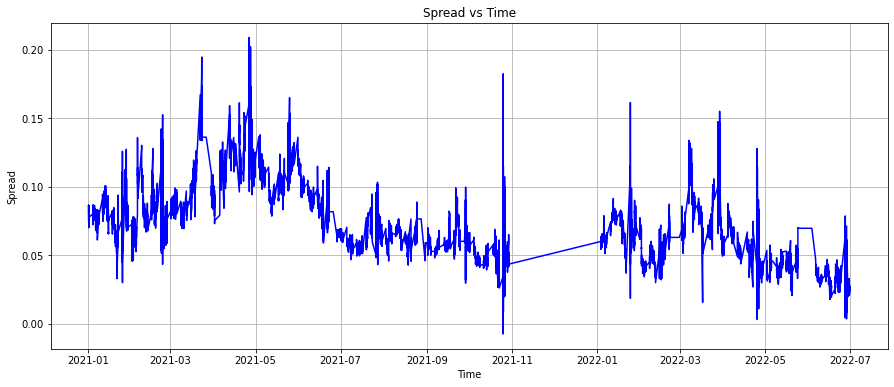

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(data['time'], data['spread'], color='blue')
plt.title('Spread vs Time')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.grid(True)
plt.show()

**Step 3: Advanced Model:**

**Performance Comparison with *Random Forest Regressor* model**

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

data_rf = data.copy()
def RFmodel(data_rf):
    # Feature Engineering
    data_rf['lag1_spread'] = data_rf['spread'].shift(1)
    data_rf['lag2_spread'] = data_rf['spread'].shift(2)
    data_rf['lag3_spread'] = data_rf['spread'].shift(3)
    
    # Drop NaN values resulting from shift operation
    data_rf.dropna(inplace=True)
    
    # Split data into features (X) and target (y)
    X = data_rf[['lag1_spread', 'lag2_spread', 'lag3_spread']].values
    y = data_rf['spread'].values
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a Random Forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = rf_regressor.predict(X_test)
    
    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    
    # Generate trading signals based on predicted spread
    data_rf['pred_spread_rf'] = rf_regressor.predict(data_rf[['lag1_spread', 'lag2_spread', 'lag3_spread']].values)
    data_rf['position'] = np.where(data_rf['pred_spread_rf'] > 0, 1, -1) 
    # Short Banknifty and Long Nifty if position is -1,
    # Long Banknifty and Short Nifty if position is 1,
    # neutral otherwise
    
    return data_rf

# Apply the Random Forest Regressor model
data_rf = RFmodel(data_rf)

# Calculate P/L using the provided formula
data_rf['P/L_adv'] = data_rf['pred_spread_rf'] * (data_rf['tte'] ** 0.7)

data_rf

Mean Squared Error: 1.7172168313751338e-05


,time,banknifty,nifty,tte,Date,Time,day_names,spread,spread_diff3,spread_zscore,position_zscore,P/L_base,lag1_spread,lag2_spread,lag3_spread,pred_spread_rf,position,P/L_adv
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,09:18:00,Friday,0.086244,-0.000085,0.512778,0,0.866325,0.084229,0.084948,0.086329,0.085372,1,0.857576
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,09:19:00,Friday,0.086588,0.001640,0.525794,0,0.869786,0.086244,0.084229,0.084948,0.086155,1,0.865434
5,2021-01-01 09:20:00,0.283431,0.198716,27,2021-01-01,09:20:00,Friday,0.084715,0.000486,0.455028,0,0.850971,0.086588,0.086244,0.084229,0.085193,1,0.855777
6,2021-01-01 09:21:00,0.280548,0.196864,27,2021-01-01,09:21:00,Friday,0.083683,-0.002561,0.416036,0,0.840605,0.084715,0.086588,0.086244,0.085300,1,0.856844
7,2021-01-01 09:22:00,0.281871,0.196726,27,2021-01-01,09:22:00,Friday,0.085145,-0.001443,0.471293,0,0.855296,0.083683,0.084715,0.086588,0.084625,1,0.850071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,15:26:00,Thursday,0.025943,0.000302,-1.765519,1,0.267320,0.025162,0.025047,0.025641,0.025603,1,0.263817
690508,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,15:27:00,Thursday,0.024317,-0.000730,-1.826972,1,0.250560,0.025943,0.025162,0.025047,0.025438,1,0.262112
690509,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,15:28:00,Thursday,0.025321,0.000159,-1.789020,1,0.260910,0.024317,0.025943,0.025162,0.024935,1,0.256929
690510,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,15:29:00,Thursday,0.026971,0.001028,-1.726679,1,0.277912,0.025321,0.024317,0.025943,0.024648,1,0.253979


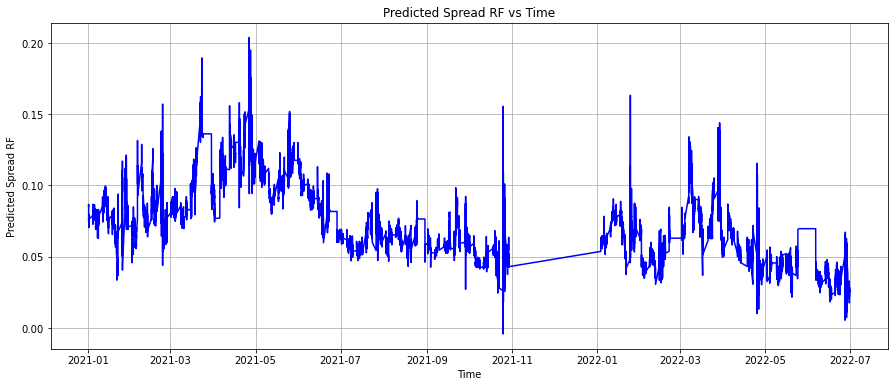

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(data_rf['time'], data_rf['pred_spread_rf'], color='blue')
plt.title('Predicted Spread RF vs Time')
plt.xlabel('Time')
plt.ylabel('Predicted Spread RF')
plt.grid(True)
plt.show()

In [18]:
#data_rf.to_excel(r"D:\PairTrading\data_MLmodel.xlsx")

In [19]:
# Step 4: Performance Comparison
def evaluate_performance(data_rf):
    # Calculate cumulative P/L for both models
    data_rf['cumulative_pl_base'] = data_rf['P/L_base'].cumsum()
    data_rf['cumulative_pl_adv'] = data_rf['P/L_adv'].cumsum()
    
    # Calculate daily returns for both models
    data_rf['daily_returns_base'] = data_rf['cumulative_pl_base'].diff()
    data_rf['daily_returns_adv'] = data_rf['cumulative_pl_adv'].diff()
    
    # Calculate metrics: Absolute P/L, Sharpe Ratio, and Drawdown
    metrics_base = {
        'Absolute P/L': data_rf['cumulative_pl_base'].iloc[-1],
        'Sharpe Ratio': data_rf['daily_returns_base'].mean() / data_rf['daily_returns_base'].std(),
        'Drawdown': (data_rf['cumulative_pl_base'] - data_rf['cumulative_pl_base'].cummax()).min()
    }
    
    metrics_advanced = {
        'Absolute P/L': data_rf['cumulative_pl_adv'].iloc[-1],
        'Sharpe Ratio': data_rf['daily_returns_adv'].mean() / data_rf['daily_returns_adv'].std(),
        'Drawdown': (data_rf['cumulative_pl_adv'] - data_rf['cumulative_pl_adv'].cummax()).min()
    }
    
    return metrics_base, metrics_advanced

# Evaluate performance of both models
metrics_base, metrics_advanced = evaluate_performance(data_rf)

# Print performance metrics
print("Base Model Performance:")
for metric, value in metrics_base.items():
    print(f"{metric}: {value}")

print("\nAdvanced Model Performance:")
for metric, value in metrics_advanced.items():
    print(f"{metric}: {value}")

Base Model Performance:
Absolute P/L: 60704.41340227368
Sharpe Ratio: 1.715833248352447
Drawdown: -0.07677310948929517

Advanced Model Performance:
Absolute P/L: 60693.513847167385
Sharpe Ratio: 1.7238052516588713
Drawdown: -0.029199080279795453


**Absolute P/L for Random Forest Regressor is slightly lesser (worse) than that for z score model.**
**Sharpe Ratio for Random Forest Regressor is better than that for z score model.**
**Drawdown for Random Forest Regressor is better than that for z score model**

**Performance Comparison with *Linear Regression* model**

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data_lr = data.copy()

def LRmodel(data_lr):
    # Prepare features (IVs of Nifty and Bank Nifty) and target (spread)
    X = data_lr[['nifty', 'banknifty']]
    y = data_lr['spread']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    
    # Generate trading signals based on predicted spread
    data_lr['pred_spread_lr'] = model.predict(X)
    data_lr['position_adv'] = np.where(data_lr['pred_spread_lr'] > 0, 1, 0)
    data_lr['position_adv'] = np.where(data_lr['pred_spread_lr'] < 0, -1, data_lr['position_adv'])
    
    return data_lr

# Short Banknifty and Long Nifty if position_adv is -1,
# Long Banknifty and Short Nifty if position_adv is 1,
# neutral otherwise


# Apply the Linear Regression model
data_lr = LRmodel(data_lr)

# Calculate P/L using the provided formula
data_lr['P/L_adv'] = data_lr['pred_spread_lr'] * (data_lr['tte'] ** 0.7)

data_lr

Mean Squared Error: 6.0710333109075364e-33


,time,banknifty,nifty,tte,Date,Time,day_names,spread,spread_diff3,spread_zscore,position_zscore,P/L_base,pred_spread_lr,position_adv,P/L_adv
0,2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01,09:15:00,Friday,0.086329,NaN,0.516009,0,0.867184,0.086329,1,0.867184
1,2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01,09:16:00,Friday,0.084948,NaN,0.463850,0,0.853317,0.084948,1,0.853317
2,2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01,09:17:00,Friday,0.084229,NaN,0.436666,0,0.846089,0.084229,1,0.846089
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,09:18:00,Friday,0.086244,-0.000085,0.512778,0,0.866325,0.086243,1,0.866325
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,09:19:00,Friday,0.086588,0.001640,0.525794,0,0.869786,0.086588,1,0.869786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,15:26:00,Thursday,0.025943,0.000302,-1.765519,1,0.267320,0.025943,1,0.267320
690508,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,15:27:00,Thursday,0.024317,-0.000730,-1.826972,1,0.250560,0.024317,1,0.250560
690509,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,15:28:00,Thursday,0.025321,0.000159,-1.789020,1,0.260910,0.025321,1,0.260910
690510,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,15:29:00,Thursday,0.026971,0.001028,-1.726679,1,0.277912,0.026971,1,0.277912


In [21]:
# Evaluate performance of both models
metrics_base, metrics_advanced = evaluate_performance(data_lr)

# Print performance metrics
print("Base Model Performance:")
for metric, value in metrics_base.items():
    print(f"{metric}: {value}")

print("\nAdvanced Model Performance:")
for metric, value in metrics_advanced.items():
    print(f"{metric}: {value}")

Base Model Performance:
Absolute P/L: 60706.97999280558
Sharpe Ratio: 1.7158514648562382
Drawdown: -0.07677310948929517

Advanced Model Performance:
Absolute P/L: 60706.97999280558
Sharpe Ratio: 1.7158514648562402
Drawdown: -0.07677310948929517


**Absolute P/L, Sharpe Ratio, and Drawdown for both Linear Regression model and for z score model have the values very close to each other. Hence, cannot say which one is better.**

**Performance Comparison with Support Vector Machine model**

In [22]:
from sklearn.svm import SVR

data_svm = data.copy()

def svm_model(data_svm):
    # Prepare features (IVs of Nifty and Bank Nifty) and target (spread)
    X = data_svm[['banknifty', 'nifty']]
    y = data_svm['spread']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Support Vector Machine Regressor model
    model = SVR(kernel='rbf')
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    
    # Generate trading signals based on predicted spread
    data_svm['pred_spread_svm'] = model.predict(X)
    data_svm['position_adv'] = np.where(data_svm['pred_spread_svm'] > 0, 1, 0)
    data_svm['position_adv'] = np.where(data_svm['pred_spread_svm'] < 0, -1, data_svm['position_adv'])
    
    return data_svm

# Short Banknifty and Long Nifty if position_adv is -1,
# Long Banknifty and Short Nifty if position_adv is 1,
# neutral otherwise

# Apply the SVM model
data_svm = svm_model(data_svm)

# Calculate P/L using the provided formula
data_svm['P/L_adv'] = data_svm['pred_spread_svm'] * (data_svm['tte'] ** 0.7)

data_svm

Mean Squared Error: 0.001230884313743094


,time,banknifty,nifty,tte,Date,Time,day_names,spread,spread_diff3,spread_zscore,position_zscore,P/L_base,pred_spread_svm,position_adv,P/L_adv
0,2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01,09:15:00,Friday,0.086329,NaN,0.516009,0,0.867184,0.098304,1,0.987474
1,2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01,09:16:00,Friday,0.084948,NaN,0.463850,0,0.853317,0.098243,1,0.986857
2,2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01,09:17:00,Friday,0.084229,NaN,0.436666,0,0.846089,0.098141,1,0.985833
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,09:18:00,Friday,0.086244,-0.000085,0.512778,0,0.866325,0.098308,1,0.987513
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,09:19:00,Friday,0.086588,0.001640,0.525794,0,0.869786,0.098259,1,0.987023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690507,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,15:26:00,Thursday,0.025943,0.000302,-1.765519,1,0.267320,0.094500,1,0.973738
690508,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,15:27:00,Thursday,0.024317,-0.000730,-1.826972,1,0.250560,0.094541,1,0.974158
690509,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,15:28:00,Thursday,0.025321,0.000159,-1.789020,1,0.260910,0.094634,1,0.975117
690510,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,15:29:00,Thursday,0.026971,0.001028,-1.726679,1,0.277912,0.094724,1,0.976047


In [23]:
# Evaluate performance of Base and SVM models
metrics_base, metrics_advanced = evaluate_performance(data_svm)

# Print performance metrics
print("Base Model Performance:")
for metric, value in metrics_base.items():
    print(f"{metric}: {value}")

print("\nAdvanced Model Performance:")
for metric, value in metrics_advanced.items():
    print(f"{metric}: {value}")

Base Model Performance:
Absolute P/L: 60706.97999280558
Sharpe Ratio: 1.7158514648562382
Drawdown: -0.07677310948929517

Advanced Model Performance:
Absolute P/L: 82124.20658696706
Sharpe Ratio: 2.406266716465646
Drawdown: 0.0


**All of Absolute P/L, Sharpe Ratio, and Drawdown for the Support Vector Machine model are better than that for z score model. Hence, we can say that the SVM model is better than z score model.**

### Useful references:
##### https://investopedia.com/
##### https://www.5paisa.com/